In [1]:

# Step 1: 导入必要库
import os
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from pathlib import Path

# 设置保存路径
project_root = Path("E:/MyProject/signature_project")  
exp_path = project_root / "experiments" / "simplecnn_E5(aug)"


exp_path.mkdir(parents=True, exist_ok=True)

print(f" 保存目录：{exp_path.resolve()}")


 保存目录：E:\MyProject\signature_project\experiments\simplecnn_E5(aug)


In [2]:
# Step 2: 自定义 SignatureDataset
class SignatureDataset(Dataset):
    """
    每张图像对应一个person文件夹，标签即为文件夹名。
    自动构建label_map: person001 → 0, person002 → 1 ...
    """
    def __init__(self, root_dir, transform=None):
        self.root_dir = Path(root_dir)
        self.transform = transform
        self.samples = []

        for person_dir in self.root_dir.iterdir():
            if person_dir.is_dir():
                label = person_dir.name
                for img_path in person_dir.glob("*.png"):
                    self.samples.append((img_path, label))

        self.label_map = {name: idx for idx, name in enumerate(sorted(set(label for _, label in self.samples)))}
        self.idx_to_label = {v: k for k, v in self.label_map.items()}

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert("L")
        if self.transform:
            image = self.transform(image)
        label_id = self.label_map[label]
        return image, label_id

# 数据增强设置（RandomAffine + Perspective）
train_transform = transforms.Compose([
    transforms.RandomAffine(degrees=5, translate=(0.05, 0.05)),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
    transforms.ToTensor()
])
test_transform = transforms.ToTensor()

# 设置数据路径
base_path = project_root / "data_splits"

# 创建数据集对象
train_dataset = SignatureDataset(base_path / "train", train_transform)
val_dataset   = SignatureDataset(base_path / "val", test_transform)
test_dataset  = SignatureDataset(base_path / "test", test_transform)


## 数据增强策略（用于训练集）

为增强模型对复杂签名风格（如连笔、倾斜、结构扭曲等）的鲁棒性，本项目在训练集中引入了以下两种数据增强方法：

- **仿射变换（RandomAffine）**：对图像进行轻微的旋转和平移操作，以模拟签名在采集过程中的位置偏移和角度误差。
- **透视变换（RandomPerspective）**：引入随机的图像扭曲，增强模型对因书写习惯或拍摄视角造成的结构变化的适应能力。

通过上述数据增强，训练数据能够更好地覆盖现实中的签名变异情况，有助于提升识别模型的泛化能力与稳定性。


In [4]:
# Step 3: 定义CNN模型结构

class SimpleCNN(nn.Module):
    """
    简单 CNN 网络，用于分类签名属于哪位用户（多分类）。
    """
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(64 * 38 * 55, 256), nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    # 前向传播方法
    def forward(self, x):
        return self.model(x)



In [5]:
# Step 4: 加载数据

# 数据增强设置（RandomAffine + Perspective）
train_transform = transforms.Compose([
    transforms.RandomAffine(degrees=5, translate=(0.05, 0.05)),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
    transforms.ToTensor()
])
test_transform = transforms.ToTensor()

# 设置数据路径
base_path = project_root / "data_splits"

# 创建数据集对象
train_dataset = SignatureDataset(base_path / "train", train_transform)
val_dataset   = SignatureDataset(base_path / "val", test_transform)
test_dataset  = SignatureDataset(base_path / "test", test_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32)
test_loader  = DataLoader(test_dataset, batch_size=32)

num_classes = len(train_dataset.label_map)
print("总共签名类别数（用户数）:", num_classes)




总共签名类别数（用户数）: 55


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SimpleCNN(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

best_val_acc = 0
patience = 5
trigger_times = 0

for epoch in range(25):
    model.train()
    epoch_loss = 0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    # 验证阶段
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    val_acc = correct / total
    print(f"Epoch {epoch+1}, Train Loss: {epoch_loss:.4f}, Val Acc: {val_acc:.4f}")

    # EarlyStopping逻辑
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        trigger_times = 0
        torch.save(model.state_dict(), exp_path / "best_model.pth")
        print(f"模型已保存至: {(exp_path / 'best_model.pth').resolve()}")
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print("Early stopping activated.")
            break


Epoch 1, Train Loss: 116.4906, Val Acc: 0.0455
模型已保存至: E:\MyProject\signature_project\experiments\simplecnn_E5(aug)\best_model.pth
Epoch 2, Train Loss: 97.9847, Val Acc: 0.5091
模型已保存至: E:\MyProject\signature_project\experiments\simplecnn_E5(aug)\best_model.pth
Epoch 3, Train Loss: 68.8692, Val Acc: 0.6455
模型已保存至: E:\MyProject\signature_project\experiments\simplecnn_E5(aug)\best_model.pth
Epoch 4, Train Loss: 52.4099, Val Acc: 0.7364
模型已保存至: E:\MyProject\signature_project\experiments\simplecnn_E5(aug)\best_model.pth
Epoch 5, Train Loss: 41.5977, Val Acc: 0.8182
模型已保存至: E:\MyProject\signature_project\experiments\simplecnn_E5(aug)\best_model.pth
Epoch 6, Train Loss: 38.5426, Val Acc: 0.8273
模型已保存至: E:\MyProject\signature_project\experiments\simplecnn_E5(aug)\best_model.pth
Epoch 7, Train Loss: 31.8048, Val Acc: 0.8273
Epoch 8, Train Loss: 27.3387, Val Acc: 0.8455
模型已保存至: E:\MyProject\signature_project\experiments\simplecnn_E5(aug)\best_model.pth
Epoch 9, Train Loss: 25.1607, Val Acc: 0.85

              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000         6
           1     0.6667    1.0000    0.8000         6
           2     0.8333    0.8333    0.8333         6
           3     1.0000    1.0000    1.0000         6
           4     0.8333    0.8333    0.8333         6
           5     0.7143    0.8333    0.7692         6
           6     1.0000    0.5000    0.6667         6
           7     0.5714    0.6667    0.6154         6
           8     0.7500    1.0000    0.8571         6
           9     0.8571    1.0000    0.9231         6
          10     0.7500    1.0000    0.8571         6
          11     0.6250    0.8333    0.7143         6
          12     0.8000    0.6667    0.7273         6
          13     0.8571    1.0000    0.9231         6
          14     0.8000    0.6667    0.7273         6
          15     0.7500    0.5000    0.6000         6
          16     1.0000    0.8333    0.9091         6
          17     0.6667    

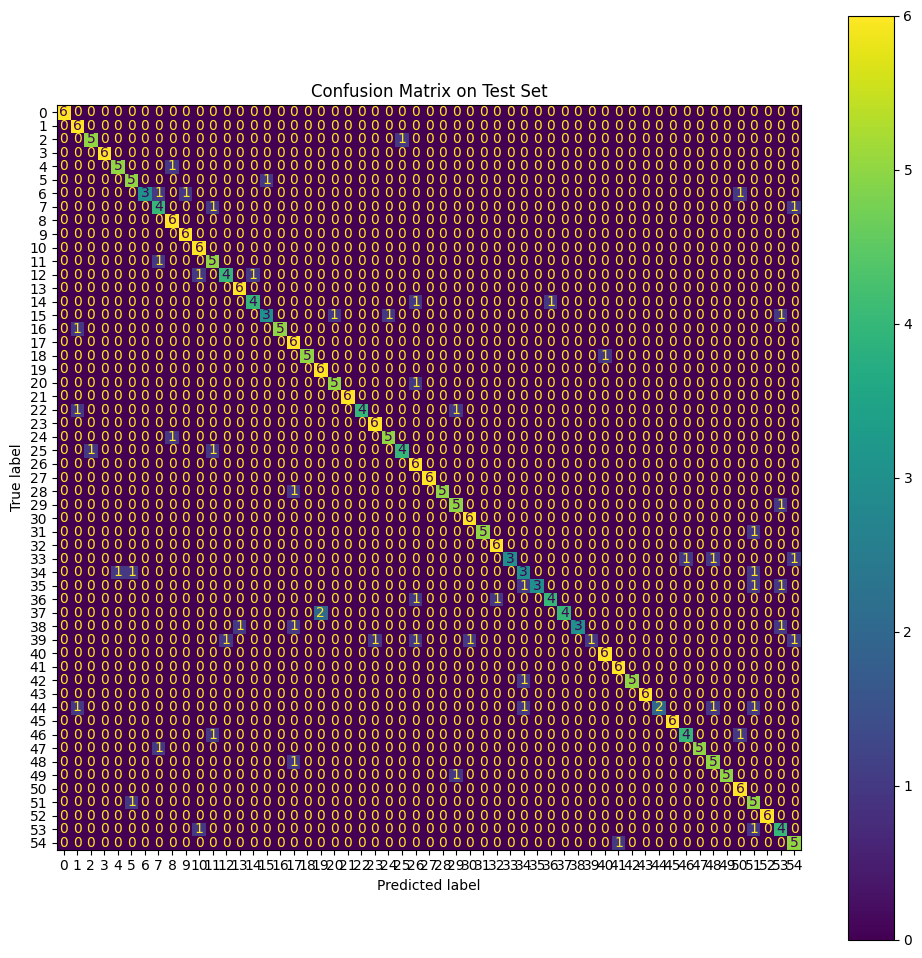

In [14]:
# Step 6: 测试集评估

# 加载最优模型
model.load_state_dict(torch.load(exp_path / "best_model.pth"))
model.eval()

y_true, y_pred = [], []
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        outputs = model(imgs)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        y_pred.extend(preds)
        y_true.extend(labels.numpy())

# 保存 classification report
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
report = classification_report(y_true, y_pred, digits=4)
print(report)

# 定义保存路径
report_path = exp_path / "classification_report.txt"

# 保存到文件
with open(report_path, "w") as f:
    f.write(report)

# 打印保存路径
print(f"分类报告已保存至: {report_path.resolve()}")


# 混淆矩阵图像保存
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
fig, ax = plt.subplots(figsize=(12, 12))
disp.plot(ax=ax, colorbar=True)
plt.title("Confusion Matrix on Test Set")
plt.savefig(exp_path / "confusion_matrix.png")
print(f"混淆矩阵图像型保存至: {(exp_path / 'confusion_matrix.png').resolve()}")

plt.show()

